Lau Jun Kit Darrick, dl5215, 01112514
# 1. Regression Methods
## 1.1 Processing Stock Price Data in Python
### 1.1.1 Time-series Plot

Let's start with a basic sanity check by visualising the types of the dataset.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
%matplotlib inline

data = pd.read_csv("../data/priceData.csv")
print(data.dtypes)
data.isnull().sum()

date          object
SPX Index    float64
dtype: object


date           0
SPX Index    655
dtype: int64

We see that there are actually 655 null values present in the `SPX Index` column, where we expect a `float64`. Additionally, the `Date` column is not required, so let's get rid of it.

<AxesSubplot:title={'center':'Logarithmic Price Graph'}>

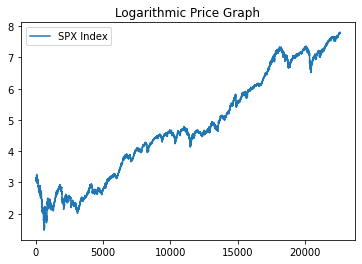

In [3]:
px = data.drop(['date'], axis=1)
px = px.interpolate()

# Now, we can do element-wise logarithmic scaling.
logpx = np.log(px)
logpx.plot(title="Logarithmic Price Graph")

### 1.1.2 Sliding Mean & Variance

<AxesSubplot:title={'center':'Standard Deviation'}>

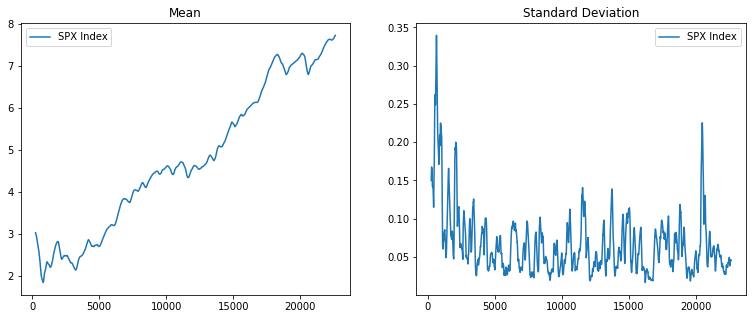

In [11]:
figure, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)

# Sliding Mean & S.D.
figure.set_size_inches(13,5)
logpx.rolling(252).mean().plot(ax=axes[0,0], title="Mean")
logpx.rolling(252).std().plot(ax=axes[0,1], title="Standard Deviation")

Taking a sliding window of 252 days, it can be observed that there is an upward trend in the mean with no discernable seasonal pattern. Spikes in variance represent corrections or market crashes, where large relative daily changes in price are observed. This time-series is therefore not stationary on its own, and will require additional mathematical manupulation to reach stationarity.

### 1.1.3 Simple & Log-return Time Series (TODO)

<AxesSubplot:title={'center':'252-day Sliding Window S.D. of Log-diff returns'}>

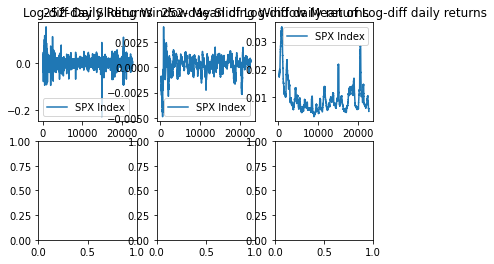

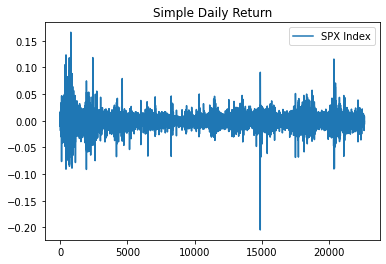

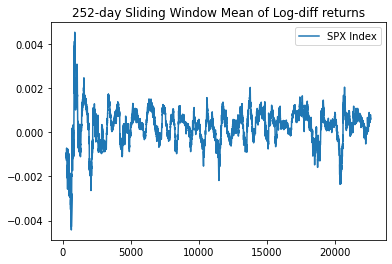

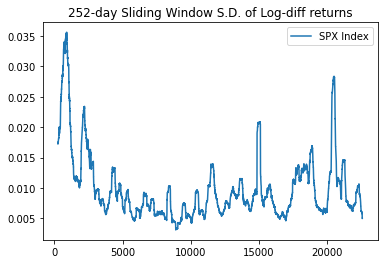

In [14]:
figure.clf()
figure, axes = plt.subplots(nrows=2, ncols=3)

logret = logpx.diff()
logret.plot(title="Log-diff Daily Returns", ax=axes[0,0])
logret.rolling(252).mean().plot(title="252-day Sliding Window Mean of Log-diff daily returns", ax=axes[0,1])
logret.rolling(252).std().plot(title="252-day Sliding Window Mean of Log-diff daily returns", ax=axes[0,2])


simpret = px.pct_change()
simpret.plot(title="Simple Daily Return", ax=axes[1,0])
simpret.rolling(252).mean().plot(title="252-day Sliding Window Mean of Log-diff returns", ax=axes[1,1])
simpret.rolling(252).std().plot(title="252-day Sliding Window S.D. of Log-diff returns", ax=axes[1,2])

Comparing the two plots, we see the property of the natural logarithm where $ Log(1+r) \approx Log(1) + Log(r) $ for small $r$. In fact, the two graphs are almost indistinguishable as daily percentage changes in the S&P500 are usually very small, except for a few outlying points.

### 1.1.4 Theoretically justify the suitability of log returns over simple returns for signal processing purposes. Next, perform the “Jarque-Bera” test for Gaussianity on the data, and comment on the results in light of your theoretical answer

In [130]:
from scipy import stats
# return the Jarque−Bera test p−value for a time−series x 
pd.DataFrame(data=np.array([[stats.jarque_bera(px)[1], stats.jarque_bera(logpx)[1], stats.jarque_bera(logret.dropna())[1], stats.jarque_bera(simpret.dropna())[1]]]), columns=["Price", "Log-price", "Log-diff", "Simple % Change"])

,Price,Log-price,Log-diff,Simple % Change
0,0.0,0.0,0.0,0.0


### 1.1.5 You purchase a stock for £1. The next day its value goes up to £2 and the following day back to £1. What are the simple and logarithmic returns over this period and what can you conclude about logarithmic returns on the basis of this example?

We see from the simple script that the price movement that the movement of the log-price matches that of the original price. An increase of $1 (100%) followed by a decrease of the same amount (50%) results in 2 equal and opposite movements of 0.693 in the logarithm. However, the percentage price is different in both cases. Logarithmic returns thus allow us to track and analyse a series of gains and losses in a more symmetric and predictable way than simple returns.

In [132]:
simple_stock_price = pd.DataFrame(data=[1,2,1], columns=["Price"])
simple_stock_price['Simple Return'] = simple_stock_price.pct_change()
simple_stock_price['Log-price Diff'] = np.log(simple_stock_price['Price']).diff()
simple_stock_price

,Price,Simple Return,Log-price Diff
0,1,NaN,NaN
1,2,1.0,0.693147
2,1,-0.5,-0.693147


### 1.1.6 Under what circumstances should you not use log returns over simple returns?

Log 

## 1.1.2 ARMA vs. ARIMA Models for Financial Applications

### 1.2.1 Plot the S&P500 time-series. Following the process in Question 1.1.1, comment on whether an ARMA or ARIMA model would be more appropriate.

In [154]:
import pandas as pd
import matplotlib . pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.ar_model import AR 
import copy

# Let's do our usual sanity check of checking the data for nulls.
snp = pd.read_csv("../data/snp_500_2015_2019.csv")
print(snp.head(5))
print(snp.isna().sum())


         Date         High          Low         Open        Close      Volume  \
0  2015-01-02  2072.360107  2046.040039  2058.899902  2058.199951  2708700000   
1  2015-01-05  2054.439941  2017.339966  2054.439941  2020.579956  3799120000   
2  2015-01-06  2030.250000  1992.439941  2022.150024  2002.609985  4460110000   
3  2015-01-07  2029.609985  2005.550049  2005.550049  2025.900024  3805480000   
4  2015-01-08  2064.080078  2030.609985  2030.609985  2062.139893  3934010000   

     Adj Close  
0  2058.199951  
1  2020.579956  
2  2002.609985  
3  2025.900024  
4  2062.139893  
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


<AxesSubplot:xlabel='Date'>

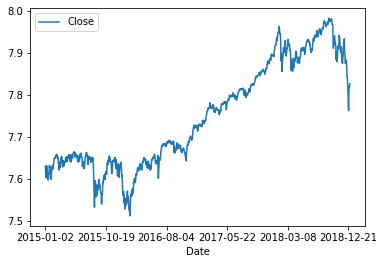

In [155]:
snp.set_index(["Date"], inplace=True)
snp_close = snp["Close"].to_frame().apply(np.log)
snp_close.plot()

We see from the data that this time series is clearly not stationary, and so an ARIMA method would be more appropriate.

### 1.2.2 Fit an ARMA(1, 0) model using the commands below. Plot, in the same figure, both the prediction and the true signal. Inspect the model parameters (model.params). Comment on the results. Are these findings useful in practice?

In [ ]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = [‘True’]
snp_arma[‘Res’] =ARIMA(snp_arma, order=(1,0,0)).fit().resid
snp_arma[ ‘ Prediction ’] = snp_arma[ ‘True ’] − snp_arma[ ‘Res ’]

### 1.2.3 Repeat Question 1.2.2, this time by fitting an ARIMA(1, 1, 0) model. Comment on the results. Compare your results with those in Question 1.2.2. Which analysis is more physically meaningful?

### 1.2.4 Comment on the necessity of taking the log of the prices for the ARIMA analysis.